In [1]:
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# MD Stuff
import MDAnalysis as mda

# Utils
from tqdm import tqdm
import pickle

# SBI
import torch
import sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn


In [2]:
def gen_quat(size):
    #Sonya's code
    
    #np.random.seed(0)
    quaternions = np.zeros((size, 4))
    count = 0

    while count < size:

        quat = np.random.uniform(-1,1,4) #note this is a half-open interval, so 1 is not included but -1 is
        norm = np.sqrt(np.sum(quat**2))

        if ( 0.2 <= norm <= 1.0 ):
            quaternions[count] = quat/norm
            count += 1

    return quaternions

def gen_img(coord, n_pixels, pixel_size, sigma):
    
    n_atoms = coord.shape[1]
    norm =  (2 * np.pi * sigma**2 * n_atoms)

    grid_min = -pixel_size * (n_pixels - 1)*0.5
    grid_max = pixel_size * (n_pixels - 1)*0.5 + pixel_size

    grid = np.arange(grid_min, grid_max, pixel_size)

    gauss = np.exp( -0.5 * ( ((grid[:,None] - coord[0,:])/sigma)**2) )[:,None] * \
            np.exp( -0.5 * ( ((grid[:,None] - coord[1,:])/sigma)**2) )

    Icalc = gauss.sum(axis=2)

    return Icalc/norm

def load_model(fname, filter = "name CA"):

    mda_model = mda.Universe(fname)

    # Center model
    mda_model.atoms.translate(-mda_model.select_atoms('all').center_of_mass())

    # Extract coordinates
    coordinates = mda_model.select_atoms(filter).positions.T

    return coordinates

In [3]:
prior_indices = utils.BoxUniform(low=1*torch.ones(1), high=20*torch.ones(1))

In [5]:
def simulator_plain(index):

    index1 = int(torch.round(index))

    coord = load_model(f"models/state_1_{index1}.pdb")

    # quat = gen_quat(1)[0]
    # rot_mat = Rotation.from_quat(quat).as_matrix()
    # coord = np.matmul(rot_mat, coord)

    N_PIXELS = 32
    PIXEL_SIZE = 4
    SIGMA = 1
    IMG_PARAMS = (N_PIXELS, PIXEL_SIZE, SIGMA)

    image = gen_img(coord, *IMG_PARAMS)*3. 
    #+ torch.randn(N_PIXELS, N_PIXELS)

    return image

sim_plain_sbi, prior_sbi = prepare_for_sbi(simulator_plain, prior_indices)

In [6]:
indices, images = simulate_for_sbi(sim_plain_sbi, proposal=prior_sbi, num_simulations=10, num_workers=1)

Running 10 simulations.:   0%|          | 0/10 [00:00<?, ?it/s]

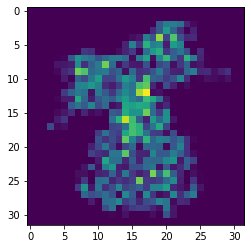

In [11]:
plt.imshow(images[2].reshape(32, 32))

In [13]:
torch.save(images, "images/images_noiseless_1d_no_rot.pt")
torch.save(indices, "images/indices_noiseless_1d_no_rot.pt")

In [14]:
images = torch.load("images/images_noiseless_1d_no_rot.pt")
indices = torch.load("images/indices_noiseless_1d_no_rot.pt")

In [15]:
density_estimator_build_fun = posterior_nn(model='maf', hidden_features=10, num_transforms=4)

inference = SNPE(prior=prior_sbi, density_estimator=density_estimator_build_fun)

inference = inference.append_simulations(indices, images)

density_estimator = inference.train()
posterior_0_1d = inference.build_posterior(density_estimator)

/mnt/home/pcossio/virtual_envs/sbi_env/lib/python3.8/site-packages/sbi/neural_nets/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn("In one-dimensional output space, this flow is limited to Gaussians")


 Neural network successfully converged after 291 epochs.

In [19]:
with open("posteriors/posterior_1d_no_rot_norm.pkl", "wb") as handle:
    pickle.dump(posterior_0_1d, handle)

In [20]:
with open("posteriors/posterior_1d_no_rot_norm.pkl", "rb") as handle:
    posterior_0_1d = pickle.load(handle)

In [22]:
true_index_1d = prior_sbi.sample((1,))

In [25]:
obs_img_1d = simulator_plain(true_index_1d)

obs_img_1d = torch.tensor(obs_img_1d.reshape(1, -1))


n_samples = 10000

samples_1d = posterior_0_1d.sample((n_samples,), x=obs_img_1d)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

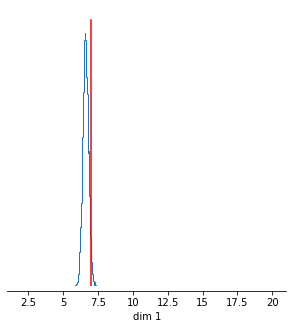

In [26]:
fig, axes = analysis.pairplot(samples_1d,
                           limits=[[1,21], [1,21]],
                           #ticks=[[2,10], [2,10]],
                           figsize=(5,5),
                           points=true_index_1d,
                           points_offdiag={'markersize': 6},
                           points_colors='r');